In [0]:
import torch
import torch.nn as nn

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [2]:
# torch.cuda.device("cuda:0")
print(torch.cuda.get_device_name())

Tesla P100-PCIE-16GB


In [130]:
flight_data = sns.load_dataset("flights")
# Create fake column
# flight_data["passengers_2"] = flight_data["passengers"] * 2 + 100
print(flight_data.head())
print(flight_data.shape)
# all_data = flight_data[["passengers", "passengers_2"]].values.astype(float)
all_data = flight_data[["passengers"]].values.astype(float)
test_data_size = 12
train_data = all_data[:-test_data_size, :]
test_data = all_data[-test_data_size:, :]
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data)
# train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

   year     month  passengers
0  1949   January         112
1  1949  February         118
2  1949     March         132
3  1949     April         129
4  1949       May         121
(144, 3)


In [131]:
print(train_data_normalized.shape)

(132, 1)


In [0]:
train_window = 12
def create_inout_sequences(
    input_data: np.ndarray, 
    tw: int,
    rg: int = 1
) -> (np.ndarray, np.ndarray):
    """
    A simpler numpy based implementation.
    """
    fea_seq, lab_seq = [], []
    L, num_attr = input_data.shape
    for i in range(L - tw):
        X = input_data[i:i+tw, :]
        y = input_data[i+tw:i+tw+rg, :]
        fea_seq.append(X)
        lab_seq.append(y)
    fea_seq = np.array(fea_seq)
    lab_seq = np.array(lab_seq)
    assert fea_seq.shape == (L - tw, tw, num_attr)
    assert lab_seq.shape == (L - tw, rg, num_attr)
    return fea_seq, lab_seq

In [133]:
X_train, y_train = create_inout_sequences(
    train_data_normalized,
    train_window
)
y_train = y_train[:, :, [0]]
X_train, y_train = map(torch.Tensor, (X_train, y_train))
print(X_train.shape)
print(y_train.shape)

torch.Size([120, 12, 1])
torch.Size([120, 1, 1])


In [0]:
# # (batch size, sequence length, input dimension)
# inp = torch.randn(batch_size, seq_len, input_dim)
# hidden_state = torch.randn(n_layers, batch_size, hidden_dim)
# cell_state = torch.randn(n_layers, batch_size, hidden_dim)
# # h0, c0 shape: (num_layers * num_directions, batch, hidden_size)
# hidden = (hidden_state, cell_state)

In [0]:
class StackedLstm(nn.Module):
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        output_size: int,
        num_layers: int,
        drop_prob: float = 0.5
    ) -> None:
        super(StackedLstm, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=self.input_size,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            # dropout=drop_prob,
            batch_first=True  # Only affect input tensor and output tensor
        )

        self.dropout = nn.Dropout(drop_prob)

        self.fc = nn.Linear(self.hidden_size, self.output_size)

        self.hidden_cell = (None, None)

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(
            # input_seq.view(len(input_seq) ,1, -1),
            # input of shape (batch, seq_len, input_size)
            input_seq,
            self.hidden_cell
        )
        # lstm output of shape (batch, seq_len, num_directions * hidden_size)
        out = self.dropout(lstm_out)
        pred = self.fc(out)
        # pred of shape (batch, seq_len, output_size)
        return pred[:, -1, :]
    
    def reset_hidden(self, batch_size) -> None:
        # both hidden h and cell c.
        self.hidden_cell = (
            torch.randn(self.num_layers, batch_size, self.hidden_size),
            torch.randn(self.num_layers, batch_size, self.hidden_size)
        )

In [144]:
model = StackedLstm(
    input_size=1,
    hidden_size=128,
    output_size=1,
    num_layers=2
)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

StackedLstm(
  (lstm): LSTM(1, 128, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


In [0]:
def batch_sampler(

) -> list:

In [145]:
EPOCHS = 150

for i in range(EPOCHS):
    # for seq, labels in train_inout_seq:
    for j in range(X_train.shape[0]):
        seq = X_train[[j], :, :]
        labels = y_train[[j], :, :]
        optimizer.zero_grad()
        # Initialize hidden states and cell states.
        model.reset_hidden(1)
        y_pred = model(seq)
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%5 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch:   1 loss: 0.05384759
epoch:   6 loss: 0.01086571
epoch:  11 loss: 0.00151745
epoch:  16 loss: 0.05379809
epoch:  21 loss: 0.03511630
epoch:  26 loss: 0.01368164
epoch:  31 loss: 0.02344675
epoch:  36 loss: 0.00950221
epoch:  41 loss: 0.01012358
epoch:  46 loss: 0.03320421
epoch:  51 loss: 0.04231893
epoch:  56 loss: 0.03249752
epoch:  61 loss: 0.07857796
epoch:  66 loss: 0.00447931
epoch:  71 loss: 0.01715816
epoch:  76 loss: 0.00856090
epoch:  81 loss: 0.00527502
epoch:  86 loss: 0.04848967
epoch:  91 loss: 0.04089855
epoch:  96 loss: 0.01135355
epoch: 101 loss: 0.01925837
epoch: 106 loss: 0.04536625
epoch: 111 loss: 0.00183091
epoch: 116 loss: 0.03890179
epoch: 121 loss: 0.01814812
epoch: 126 loss: 0.00333550
epoch: 131 loss: 0.02660323
epoch: 136 loss: 0.01284311
epoch: 141 loss: 0.00840154
epoch: 146 loss: 0.01125755
epoch: 149 loss: 0.0052112089


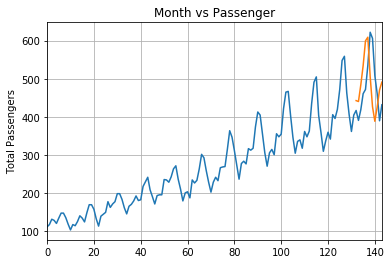

In [147]:
fut_pred = 12

test_inputs = train_data_normalized[-train_window:].tolist()

model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(
        np.array(test_inputs).astype(np.float32)[-train_window:]
    )
    seq = seq.view(1, 12, 1)
    with torch.no_grad():
        model.reset_hidden(1)
        model_out = model(seq).item()
        test_inputs.append(
            np.array([model_out])
        )
actual_predictions = scaler.inverse_transform(
    np.array(test_inputs[train_window:]).reshape(-1, 1)
)

x = np.arange(132, 132 + fut_pred, 1)

plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(flight_data['passengers'])
plt.plot(x, actual_predictions[:, 0])
plt.show()

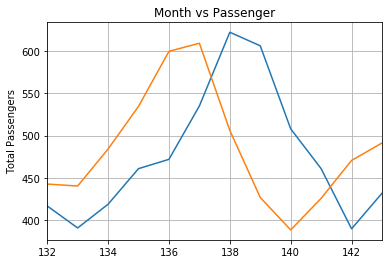

In [148]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(flight_data['passengers'][-train_window:])
plt.plot(x,actual_predictions)
plt.show()